In [1]:
library(DALEX)
library(auditor)

Welcome to DALEX (version: 0.2.5).


# Generating data

In [2]:
true_model <- function(model, data){
    return(200 + 150 * (abs(data$year_of_birth - 1000) > 500) + 0.05 * (data$height - 50)^2 + 70 * data$scars)
}

In [3]:
N <- 2000
set.seed(1313)

year_of_birth <- round(runif(N, -2000, 1800)) # year, for negative -n = n + 1 BC
year_of_discovery <- sort(round(runif(N, 1700, 1800))) # year
height <- rgamma(N, 50) # yards
weight <- 1/4 * height + rexp(N, 1) # tons
scars <- round(rexp(N, 0.1)) # number
colour <- sample(c('red', 'blue', 'green', 'black'), N, replace=TRUE, p=c(0.5, 0.3, 0.18, 0.02))
life_length <- true_model(NULL, data.frame(year_of_birth, height, weight, 
                                           scars, colour, year_of_discovery)) + rnorm(N, 0, 20)
df <- data.frame(year_of_birth, height, weight, scars, colour, year_of_discovery, life_length)

In [4]:
N <- 1000
set.seed(4242)

year_of_birth <- round(runif(N, -2000, 2000)) # year, for negative -n = n + 1 BC
year_of_discovery <- sort(round(runif(N, 1800, 2000))) # year
colour <- sample(c('red', 'blue', 'green', 'black'), N, replace=TRUE, p=c(0.4, 0.3, 0.1, 0.2))
height <- ifelse(
    colour == 'black' & year_of_discovery > 1840,
    rgamma(N, 200),
    rgamma(N, 50)
) # yards
weight <- 1/4 * height + rexp(N, 1) # tons
scars <- round(rexp(N, 0.1)) # number
life_length <- true_model(NULL, data.frame(year_of_birth, height, weight, 
                                           scars, colour, year_of_discovery)) + rnorm(N, 0, 20)
df_test <- data.frame(year_of_birth, height, weight, scars, colour, year_of_discovery, life_length)

In [5]:
head(df)
head(df_test)

year_of_birth,height,weight,scars,colour,year_of_discovery,life_length
1355,44.65054,12.82487,12,green,1700,1069.8319
-540,52.71104,18.56389,22,green,1700,1883.1912
695,47.40427,12.43831,1,red,1700,285.9589
-121,47.88570,13.39762,1,blue,1700,381.1834
425,46.19872,14.22780,4,blue,1700,640.2665
401,42.91617,12.15626,17,green,1700,1568.4039


year_of_birth,height,weight,scars,colour,year_of_discovery,life_length
1944,52.72899,14.53576,14,black,1800,1341.9766
-609,47.34525,12.12247,2,blue,1800,496.6474
-1080,44.88874,11.96229,21,blue,1800,1853.0963
675,47.82907,12.84190,18,blue,1800,1460.0822
811,53.49212,14.28875,1,blue,1801,272.5731
1738,41.37042,10.43020,20,blue,1801,1774.3387


# MODELS ON TRAIN (without concept drift)

In [6]:
lm_model <- lm(life_length ~ ., data=df)

library("e1071")
svm_model <- svm(life_length ~ ., data=df)

library(randomForest)
rf_model  <- randomForest(life_length ~ ., data=df)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


In [7]:
# generate report
# library(modelDown)

# modelDown(explain(model = 1, data = df, y = df$life_length, predict_function = true_model), 
#           explain(model = lm_model, data = df, y = df$life_length), 
#           explain(model = svm_model, data = df, y = df$life_length),
#           explain(model = rf_model, data = df, y = df$life_length))

In [8]:
lm_audit <- audit(lm_model, label = "lm", data = df, y = df$life_length)
svm_audit <- audit(svm_model, label = "svm", data = df, y = df$life_length)
rf_audit <- audit(rf_model, label = "rf", data = df, y = df$life_length)

## Model performance

In [9]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


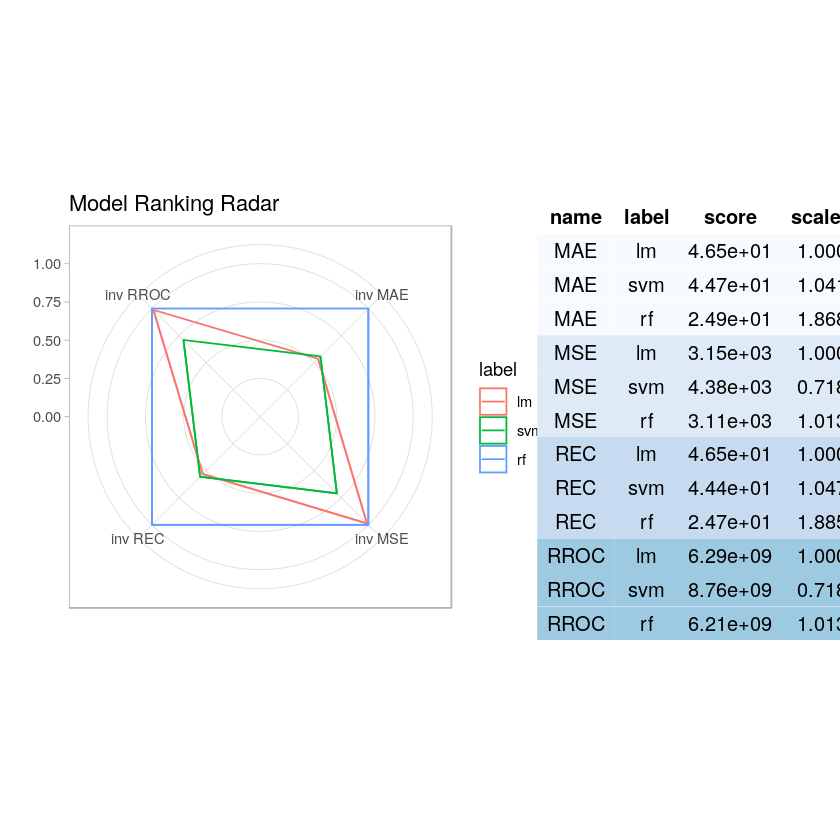

In [10]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)

## Plotting residuals

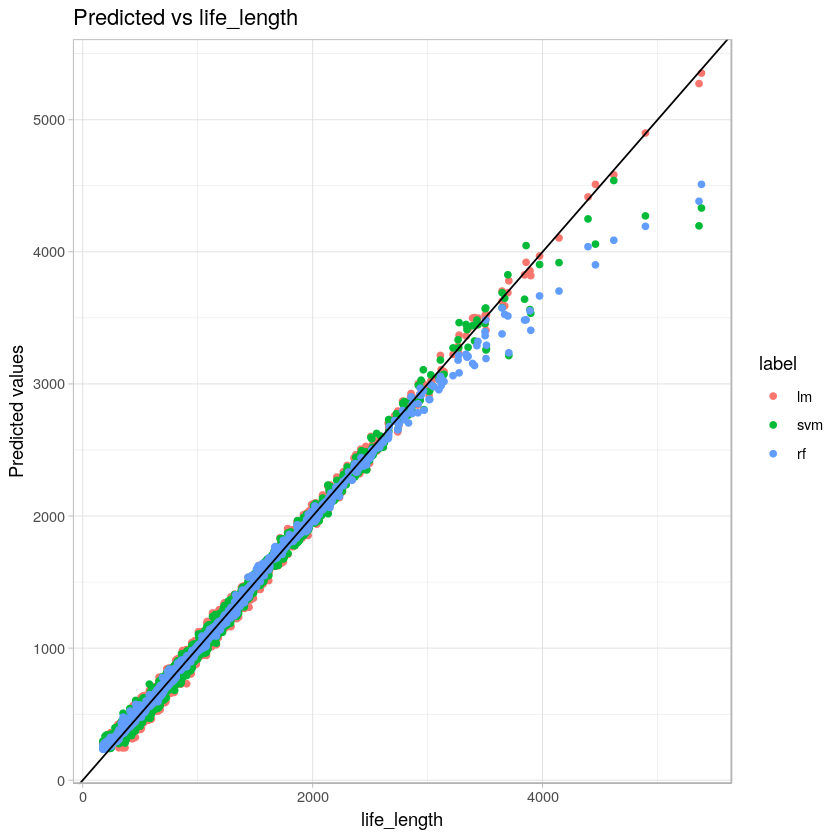

In [11]:
lm_mr_m2 <- modelResiduals(lm_audit, variable = "life_length")
svm_mr_m2 <- modelResiduals(svm_audit, variable = "life_length")
rf_mr_m2 <- modelResiduals(rf_audit, variable = "life_length")

plot(lm_mr_m2, svm_mr_m2, rf_mr_m2, type = "Prediction")

## Residual Density

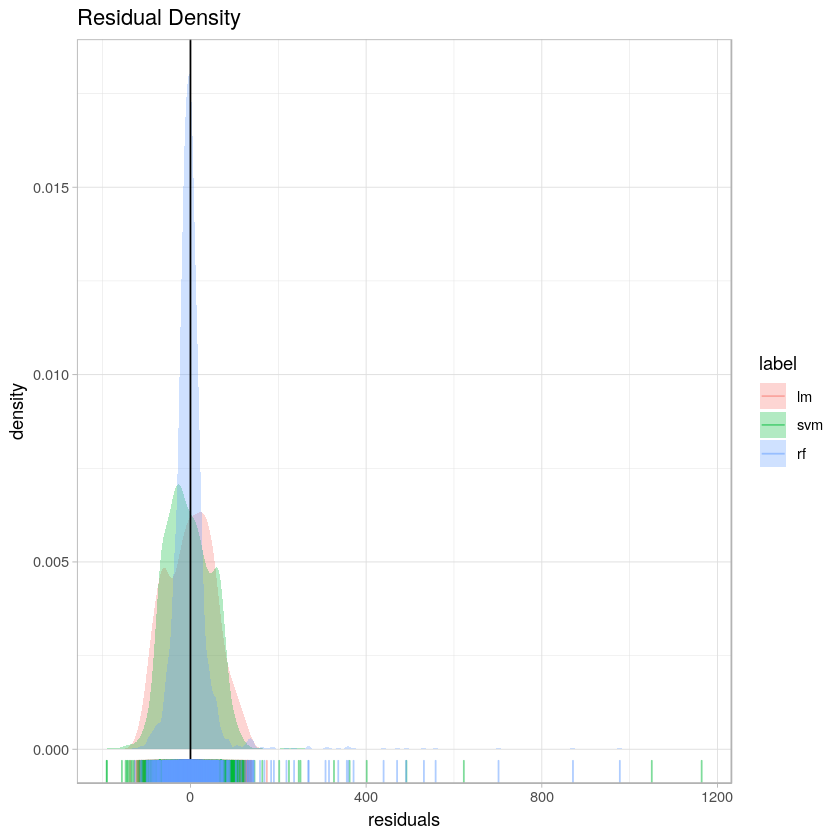

In [12]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

## Residuals vs variables

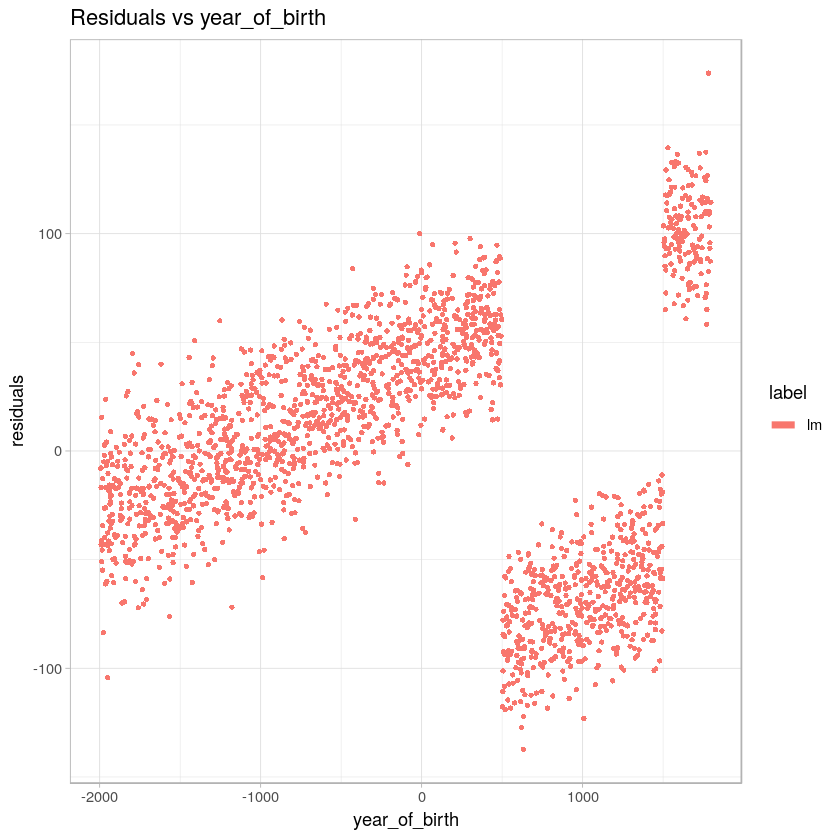

In [13]:
# plotResidual(lm_audit, variable = 'height')
# plotResidual(lm_audit, variable = 'colour')
plotResidual(lm_audit, variable = 'year_of_birth')
# plotResidual(lm_audit, variable = 'year_of_discovery')
# plotResidual(lm_audit, variable = 'scars')

In [14]:
df$period <- cut(df$year_of_birth, c(-2000, 500, 1500, 2000), 
                 labels = c('ancient', 'middle_ages', 'early_modern'), include.lowest = TRUE)
df_test$period <- cut(df_test$year_of_birth, c(-2000, 500, 1500, 2000), 
                 labels = c('ancient', 'middle_ages', 'early_modern'), include.lowest = TRUE)

head(df)
head(df_test)

year_of_birth,height,weight,scars,colour,year_of_discovery,life_length,period
1355,44.65054,12.82487,12,green,1700,1069.8319,middle_ages
-540,52.71104,18.56389,22,green,1700,1883.1912,ancient
695,47.40427,12.43831,1,red,1700,285.9589,middle_ages
-121,47.88570,13.39762,1,blue,1700,381.1834,ancient
425,46.19872,14.22780,4,blue,1700,640.2665,ancient
401,42.91617,12.15626,17,green,1700,1568.4039,ancient


year_of_birth,height,weight,scars,colour,year_of_discovery,life_length,period
1944,52.72899,14.53576,14,black,1800,1341.9766,early_modern
-609,47.34525,12.12247,2,blue,1800,496.6474,ancient
-1080,44.88874,11.96229,21,blue,1800,1853.0963,ancient
675,47.82907,12.84190,18,blue,1800,1460.0822,middle_ages
811,53.49212,14.28875,1,blue,1801,272.5731,middle_ages
1738,41.37042,10.43020,20,blue,1801,1774.3387,early_modern


## New models

In [15]:
lm_model <- lm(life_length ~ ., data=df)
svm_model <- svm(life_length ~ ., data=df)
rf_model <- randomForest(life_length ~ ., data=df)

In [16]:
# generate report
# modelDown(explain(model = 1, data = df, y = df$life_length, predict_function = true_model), 
#           explain(model = lm_model, data = df, y = df$life_length), 
#           explain(model = svm_model, data = df, y = df$life_length),
#           explain(model = rf_model, data = df, y = df$life_length))

In [17]:
lm_audit <- audit(lm_model, label = "lm", data = df, y = df$life_length)
svm_audit <- audit(svm_model, label = "svm", data = df, y = df$life_length)
rf_audit <- audit(rf_model, label = "rf", data = df, y = df$life_length)

In [18]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

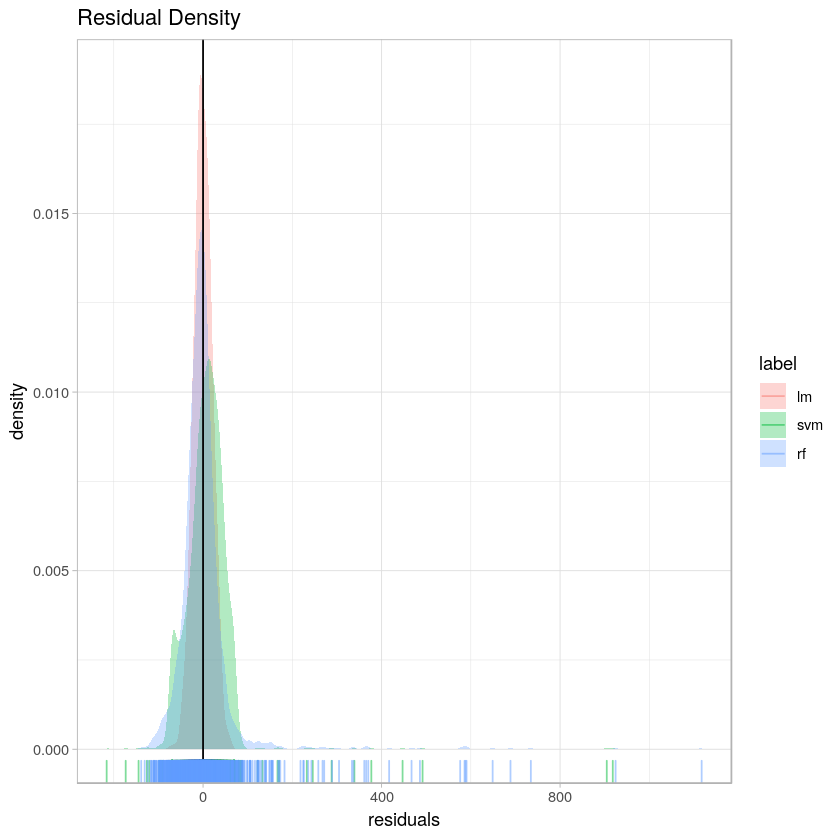

In [19]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

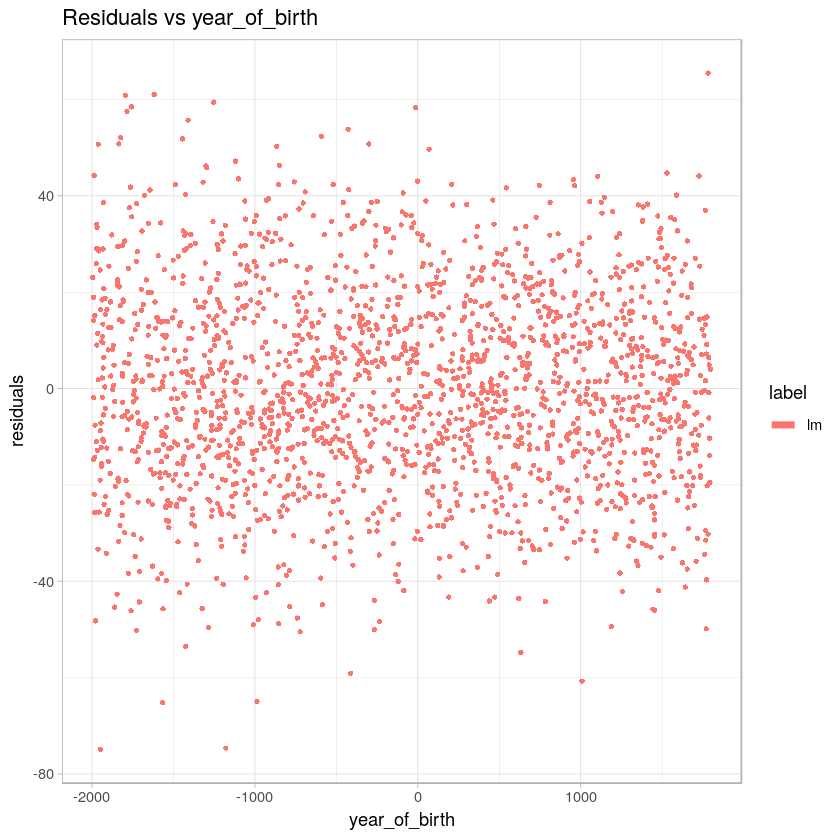

In [20]:
plotResidual(lm_audit, variable = 'year_of_birth')

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


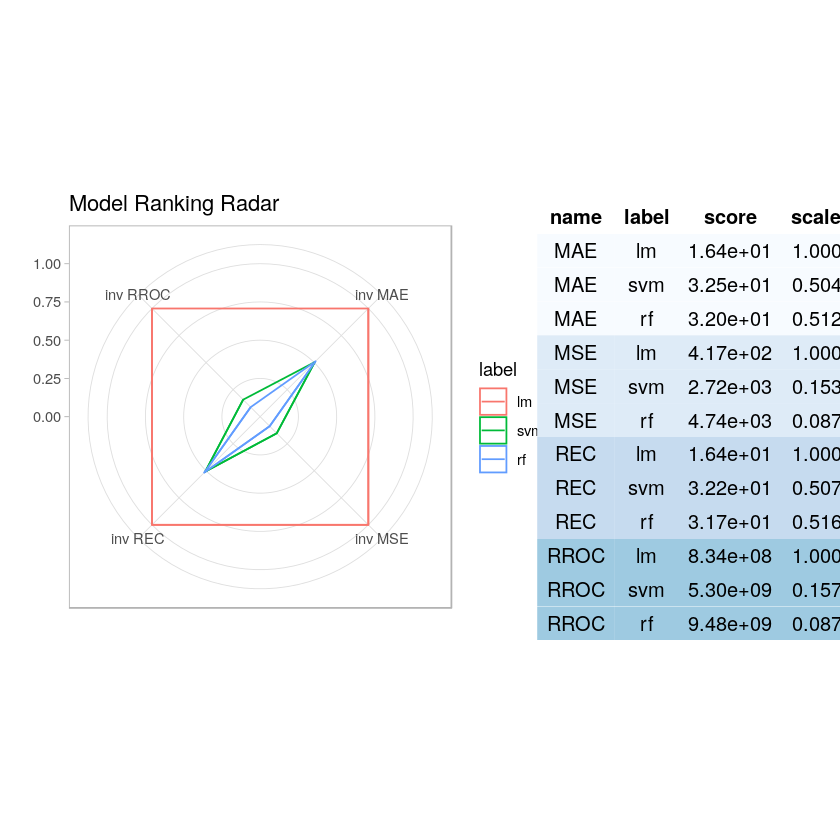

In [21]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)

# MODELS ON TEST (with concept drift)

In [22]:
lm_model <- lm(life_length ~ ., data=df)

library("e1071")
svm_model <- svm(life_length ~ ., data=df)
rf_model <- randomForest(life_length ~ ., data=df)

In [23]:
lm_audit <- audit(lm_model, label = "lm", data = df_test, y = df_test$life_length)
svm_audit <- audit(svm_model, label = "svm", data = df_test, y = df_test$life_length)
rf_audit <- audit(rf_model, label = "rf", data = df_test, y = df_test$life_length)

In [24]:
# generate report
# modelDown(explain(model = 1, data = df_test, y = df_test$life_length, predict_function = true_model), 
#           explain(model = lm_model, data = df_test, y = df_test$life_length), 
#           explain(model = svm_model, data = df_test, y = df_test$life_length),
#           explain(model = rf_model, data = df_test, y = df_test$life_length))

## Model performance

In [25]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


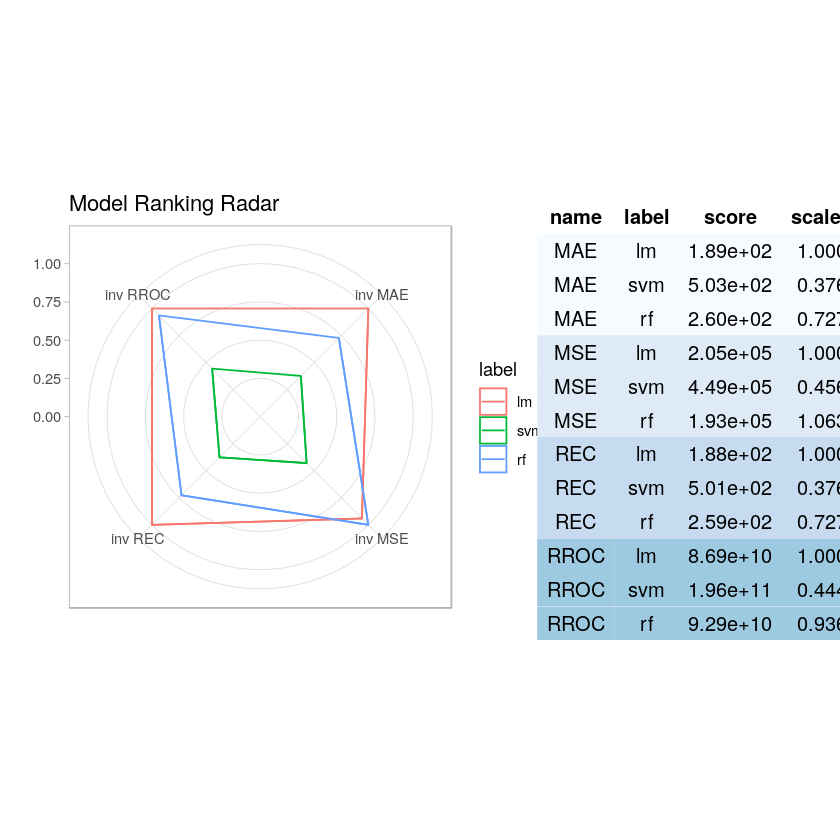

In [26]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)

## Plotting residuals

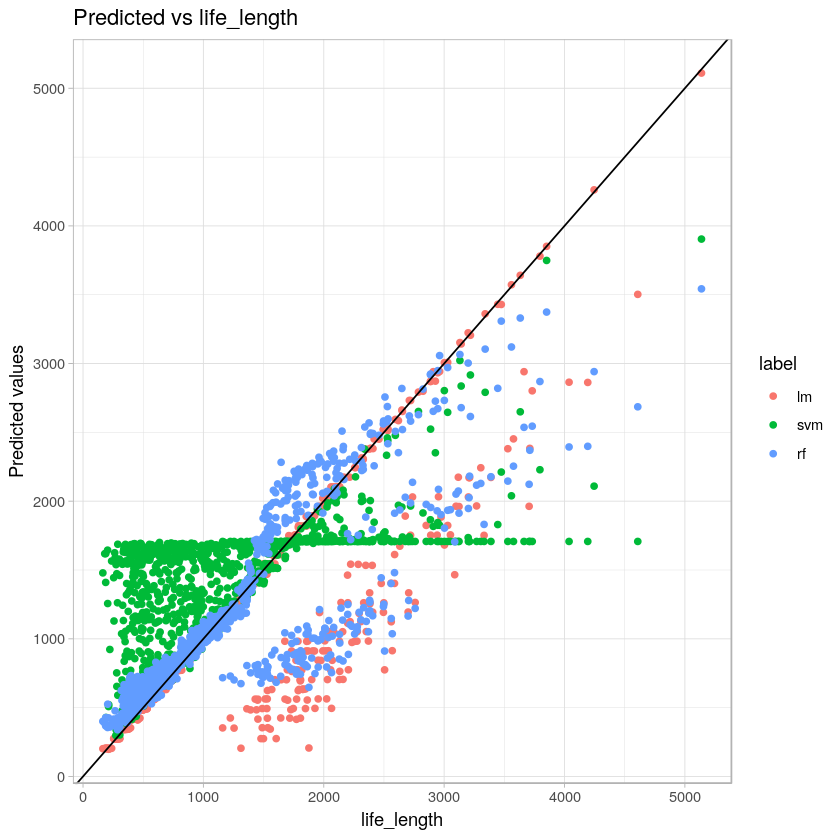

In [27]:
lm_mr_m2 <- modelResiduals(lm_audit, variable = "life_length")
svm_mr_m2 <- modelResiduals(svm_audit, variable = "life_length")
rf_mr_m2 <- modelResiduals(rf_audit, variable = "life_length")


plot(lm_mr_m2, svm_mr_m2, rf_mr_m2, type = "Prediction")

## Residual Density

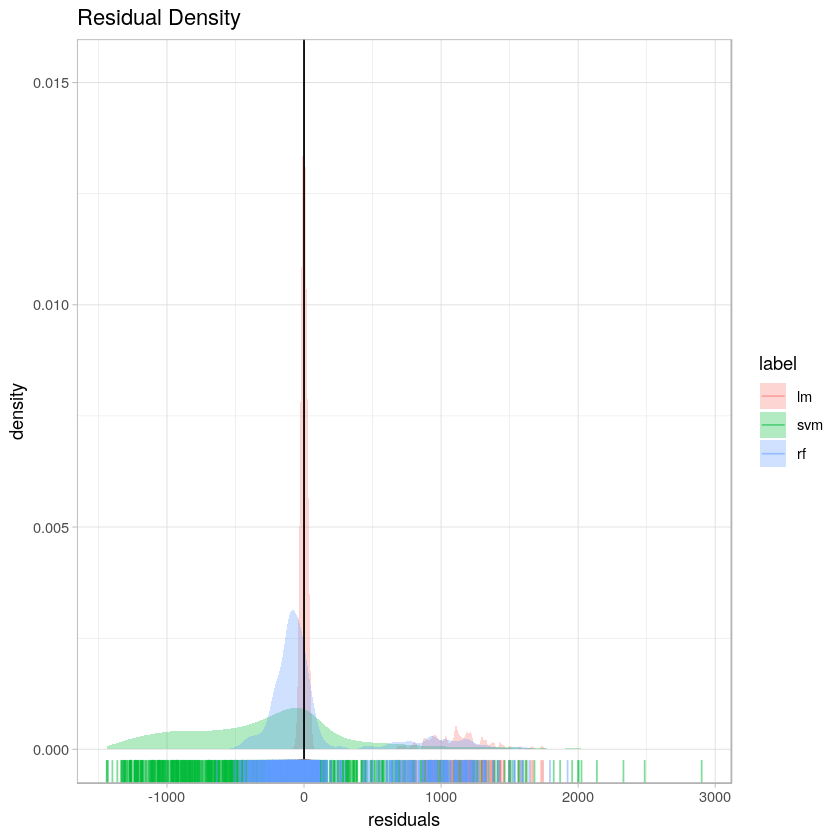

In [28]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

## Residuals vs variables

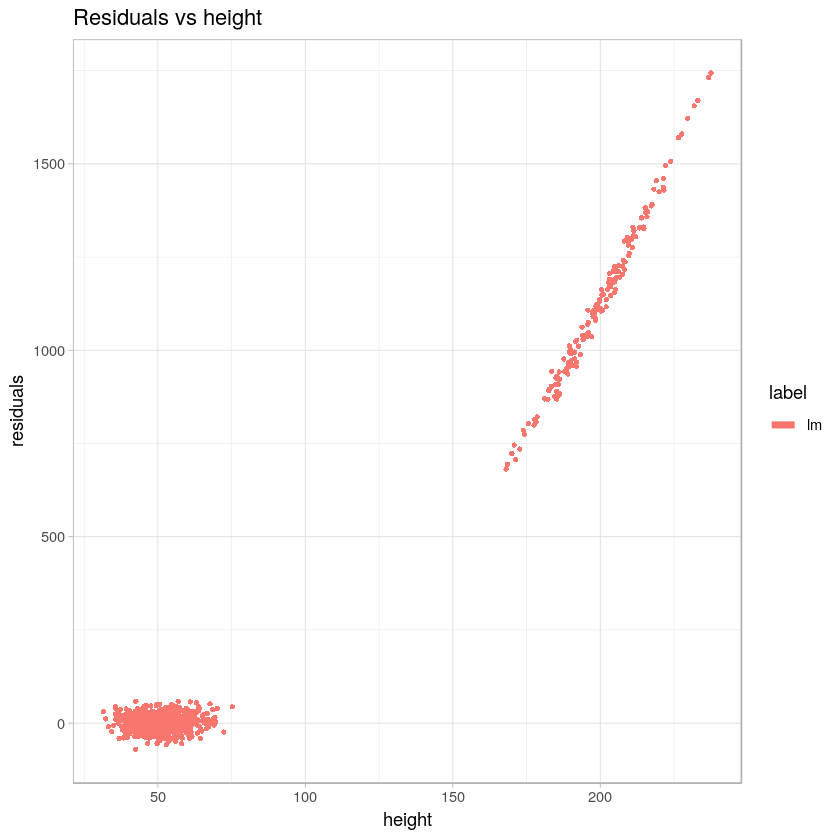

In [29]:
plotResidual(lm_audit, variable = 'height')
# plotResidual(lm_audit, variable = 'colour')
# plotResidual(lm_audit, variable = 'year_of_birth')
# plotResidual(lm_audit, variable = 'year_of_discovery')
# plotResidual(lm_audit, variable = 'scars')

In [30]:
df$height_squared <- df$height^2
df_test$height_squared <- df_test$height^2

## New models

In [31]:
lm_model <- lm(life_length ~ ., data=df)
svm_model <- svm(life_length ~ ., data=df)
rf_model <- randomForest(life_length ~ ., data=df)

In [32]:
# generate report
# modelDown(explain(model = 1, data = df_test, y = df_test$life_length, predict_function = true_model), 
#           explain(model = lm_model, data = df_test, y = df_test$life_length), 
#           explain(model = svm_model, data = df_test, y = df_test$life_length),
#           explain(model = rf_model, data = df_test, y = df_test$life_length))

In [33]:
lm_audit <- audit(lm_model, label = "lm", data = df_test, y = df_test$life_length)
svm_audit <- audit(svm_model, label = "svm", data = df_test, y = df_test$life_length)
rf_audit <- audit(rf_model, label = "rf", data = df_test, y = df_test$life_length)

In [34]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

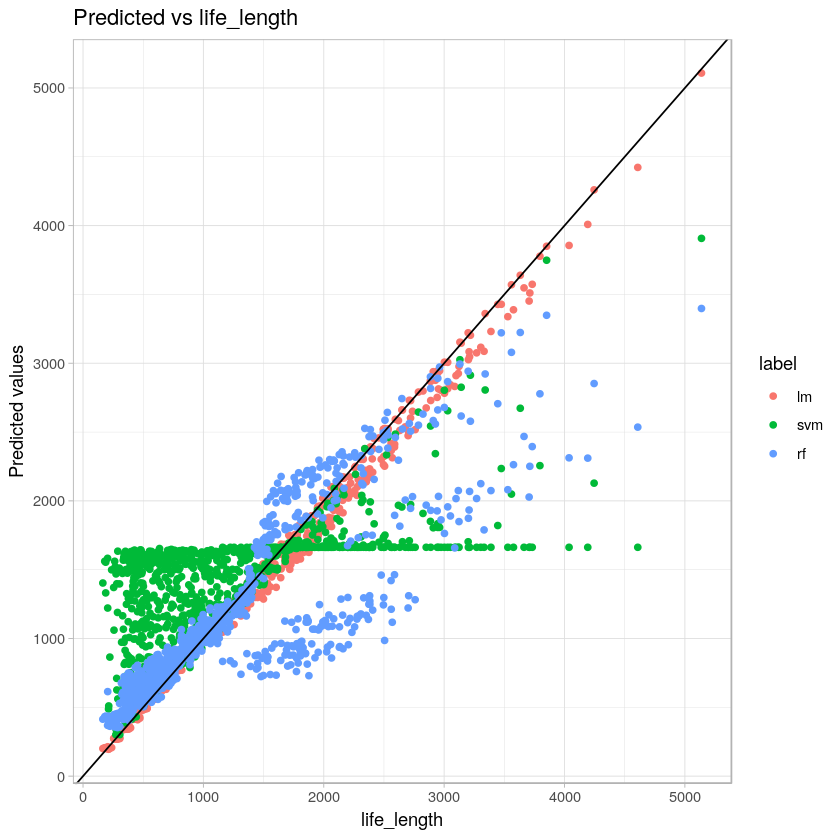

In [37]:
lm_mr_m2 <- modelResiduals(lm_audit, variable = "life_length")
svm_mr_m2 <- modelResiduals(svm_audit, variable = "life_length")
rf_mr_m2 <- modelResiduals(rf_audit, variable = "life_length")


plot(lm_mr_m2, svm_mr_m2, rf_mr_m2, type = "Prediction")

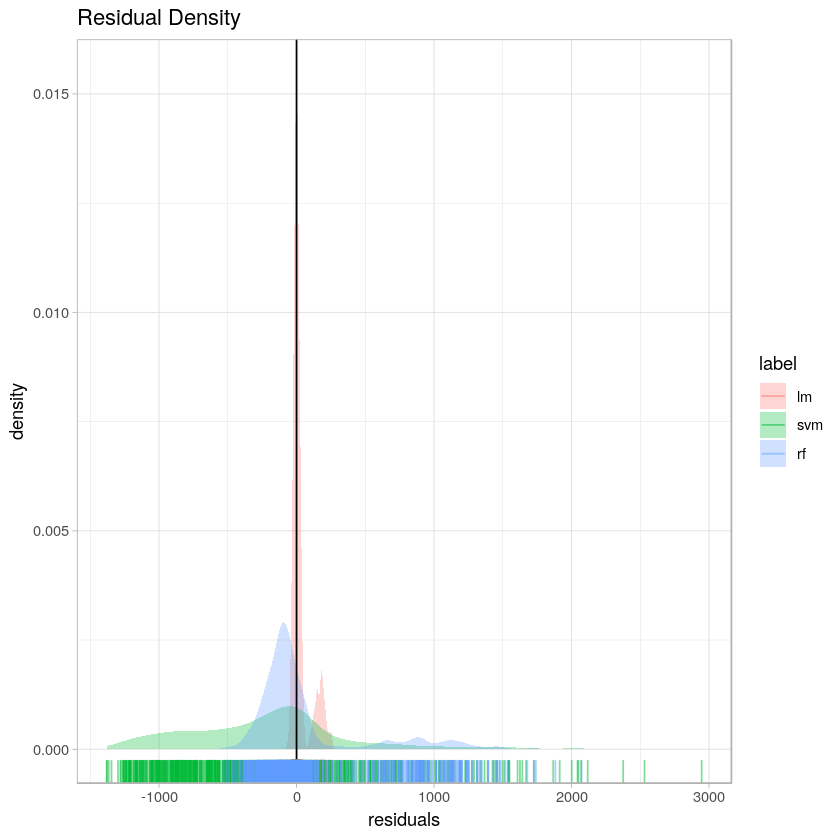

In [35]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

Much better. Now the residuals against `teeth.len`. No correlation can be seen now.

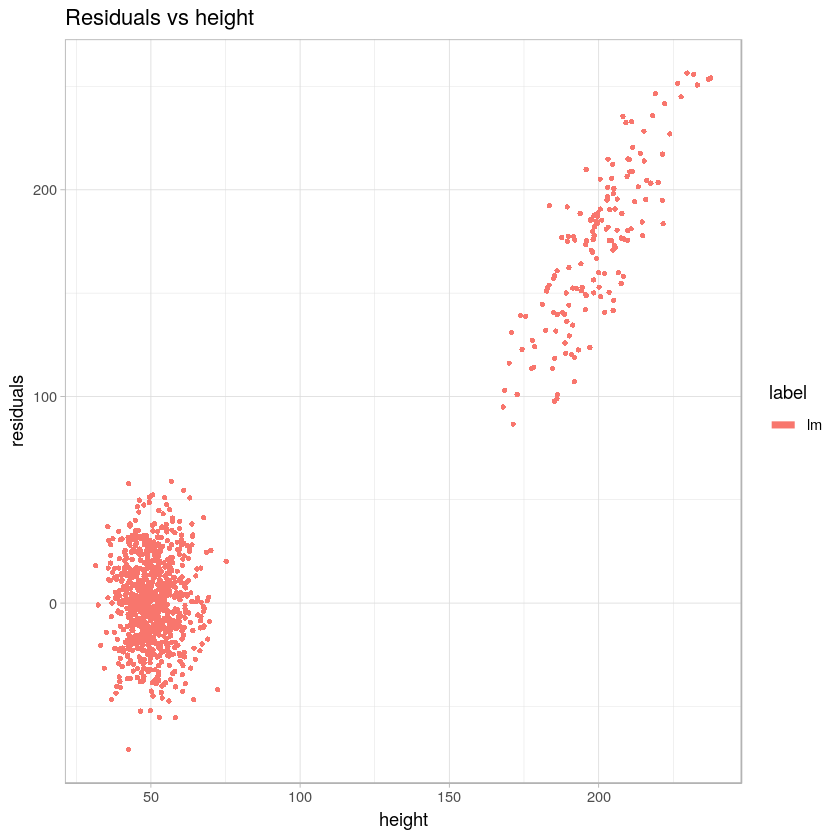

In [36]:
plotResidual(lm_audit, variable = 'height')

Let's check the performance of the models.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


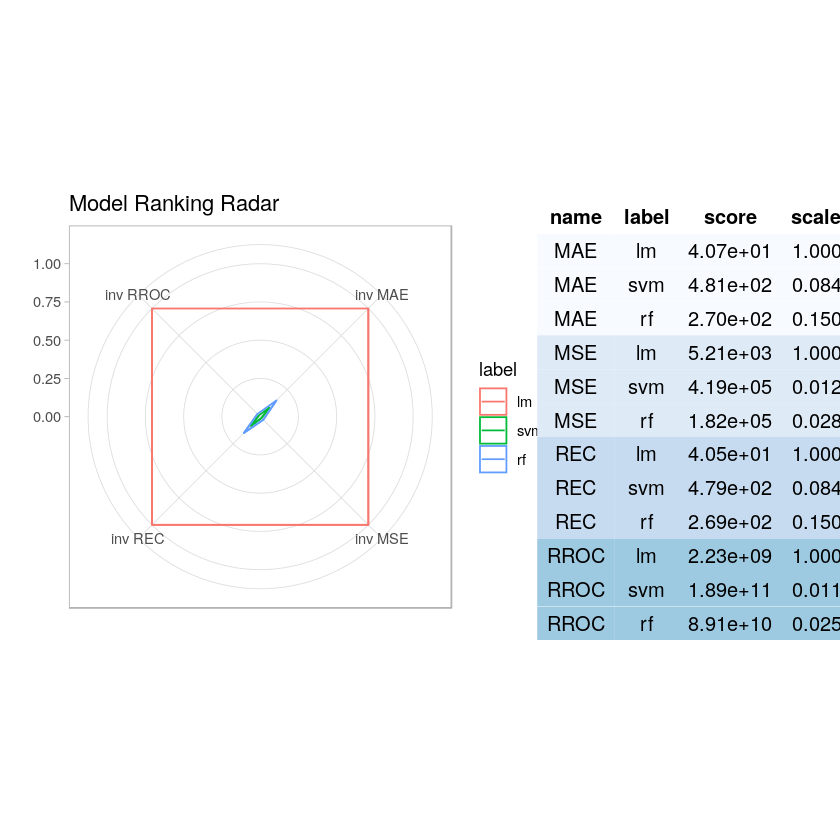

In [53]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)

Now the linear model is much better than it was before changing the variable. We were able to tweak the performance of the model by closely looking at residuals.